In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [2]:
sc = SparkContext(master='local',appName='Buoi4')
spark = SparkSession(sc)

In [3]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, log
from pyspark.sql.functions import to_date, dayofweek, to_timestamp
from pyspark.sql import types 
from pyspark.sql.functions import col, udf
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.functions import year, month
from pyspark.sql.functions import dayofmonth, weekofyear
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import coalesce, first, lit
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.functions import regexp_extract, col

df = spark.read.csv("2017_StPaul_MN_Real_Estate.csv", header=True, inferSchema=True)

df_sub = df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 
                   'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES', 
                   'ASSUMABLEMORTGAGE', 'SalesClosePrice', 'ListPrice',
                   'DAYSONMARKET')
df_sub.show(3)

+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|STREETNUMBERNUMERIC|FIREPLACES|LOTSIZEDIMENSIONS|       LISTTYPE|ACRES|ASSUMABLEMORTGAGE|SalesClosePrice|ListPrice|DAYSONMARKET|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
|              11511|         0|          279X200|Exclusive Right| 1.28|             null|         143000|   139900|          10|
|              11200|         0|          100x140|Exclusive Right| 0.32|             null|         190000|   210000|           4|
|               8583|         0|          120x296|Exclusive Right|0.822|    Not Assumable|         225000|   225000|          28|
+-------------------+----------+-----------------+---------------+-----+-----------------+---------------+---------+------------+
only showing top 3 rows



In [4]:
df_sub.columns

['STREETNUMBERNUMERIC',
 'FIREPLACES',
 'LOTSIZEDIMENSIONS',
 'LISTTYPE',
 'ACRES',
 'ASSUMABLEMORTGAGE',
 'SalesClosePrice',
 'ListPrice',
 'DAYSONMARKET']

In [5]:
df_sub = df_sub.drop('STREETNUMBERNUMERIC','LOTSIZEDIMENSIONS')

In [6]:
df_sub.columns

['FIREPLACES',
 'LISTTYPE',
 'ACRES',
 'ASSUMABLEMORTGAGE',
 'SalesClosePrice',
 'ListPrice',
 'DAYSONMARKET']

In [7]:
df_sub.select('ASSUMABLEMORTGAGE').distinct().show()

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|               null|
|Yes w/No Qualifying|
|      Not Assumable|
+-------------------+



In [8]:
yes_value= ['Yes w/ Qualifying','Yes w/No Qualifying']
text_filter = ~df_sub['ASSUMABLEMORTGAGE'].isin(yes_value) | df_sub['ASSUMABLEMORTGAGE'].isNull()

In [9]:
df_sub = df.where(text_filter)

In [10]:
df_sub.columns

['No',
 'MLSID',
 'StreetNumberNumeric',
 'streetaddress',
 'STREETNAME',
 'PostalCode',
 'StateOrProvince',
 'City',
 'SalesClosePrice',
 'LISTDATE',
 'LISTPRICE',
 'LISTTYPE',
 'OriginalListPrice',
 'PricePerTSFT',
 'FOUNDATIONSIZE',
 'FENCE',
 'MapLetter',
 'LotSizeDimensions',
 'SchoolDistrictNumber',
 'DAYSONMARKET',
 'offmarketdate',
 'Fireplaces',
 'RoomArea4',
 'roomtype',
 'ROOF',
 'RoomFloor4',
 'PotentialShortSale',
 'PoolDescription',
 'PDOM',
 'GarageDescription',
 'SQFTABOVEGROUND',
 'Taxes',
 'RoomFloor1',
 'RoomArea1',
 'TAXWITHASSESSMENTS',
 'TAXYEAR',
 'LivingArea',
 'UNITNUMBER',
 'YEARBUILT',
 'ZONING',
 'STYLE',
 'ACRES',
 'CoolingDescription',
 'APPLIANCES',
 'backonmarketdate',
 'ROOMFAMILYCHAR',
 'RoomArea3',
 'EXTERIOR',
 'RoomFloor3',
 'RoomFloor2',
 'RoomArea2',
 'DiningRoomDescription',
 'BASEMENT',
 'BathsFull',
 'BathsHalf',
 'BATHQUARTER',
 'BATHSTHREEQUARTER',
 'Class',
 'BATHSTOTAL',
 'BATHDESC',
 'RoomArea5',
 'RoomFloor5',
 'RoomArea6',
 'RoomFloor6',

In [11]:
from pyspark.sql.functions import mean,stddev,col,log

In [12]:
import seaborn as sns

In [13]:
original = df_sub.withColumn('sale',col('SalesClosePrice')).toPandas()

In [14]:
df_sub = df_sub.withColumn('log_SaleClosePrice',log(col('SalesClosePrice')))

In [15]:
sub = df_sub.select('log_SaleClosePrice').toPandas()

c:\program files\python36\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


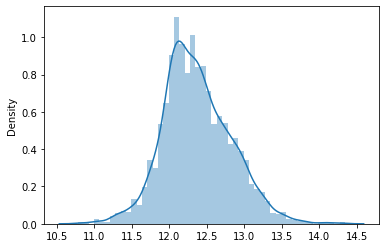

In [16]:
sns.distplot(sub);

In [17]:
mean_val = df_sub.agg({'log_SaleClosePrice':'mean'}).collect()[0][0]

In [18]:
stddev_val = df_sub.agg({'log_SaleClosePrice':'stddev'}).collect()[0][0]

In [19]:
low = mean_val - 3*stddev_val
high = mean_val - 3*stddev_val

In [20]:
df_sub.count()

4976

In [21]:
df_sub.dropna().count()

0

In [26]:
df_sub.dropna(how='all',subset=['ListPrice','SalesClosePrice']).count()

4976

In [28]:
max_price = df_sub.agg({'SalesClosePrice':'min'}).collect()[0][0]
min_price = df_sub.agg({'SalesClosePrice':'max'}).collect()[0][0]

In [30]:
df_sub = df_sub.withColumn('scaled_price',
                           (df_sub.SalesClosePrice-min_price)/(max_price-min_price))

In [44]:
df_sub.agg({'scaled_price':'max'}).collect()[0][0]

1.0

In [45]:
df_sub.agg({'scaled_price':'min'}).collect()[0][0]

-0.0

In [47]:
df_sub.select('scaled_price').show(5)

+------------------+
|      scaled_price|
+------------------+
|0.9424939467312349|
| 0.914043583535109|
|0.8928571428571429|
|0.8686440677966102|
|0.8777845036319613|
+------------------+
only showing top 5 rows



In [55]:
roof = df[['ROOF']]

In [56]:
roof.where(df['ROOF'].isNull()).count()

765

In [57]:
roof_df = roof.toPandas()

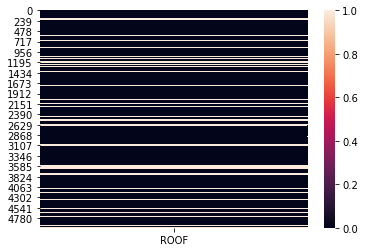

In [59]:
sns.heatmap(roof_df.isnull());

In [60]:
df.ROOF

Column<b'ROOF'>

In [61]:
df[['ROOF']].is

DataFrame[ROOF: string]

In [64]:
df_sub.where(df_sub.SalesClosePrice.isNull()).count()

0

In [71]:
df.filter(df.ROOF.isNull()).count()

765

In [72]:
PDOM_plot = df.select('PDOM').toPandas()